In [ ]:
# need this code snippet in each notebook to mount the google drive
from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls "/content/gdrive/My Drive/house-prices-advanced-regression-techniques"

 data_description.txt	  sample_submission.csv   test.csv
'House Prices NN.ipynb'   submission.csv	  train.csv


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
print(os.listdir("/content/gdrive/My Drive/house-prices-advanced-regression-techniques"))

#from d2l import tensorflow as d2l
import tensorflow as tf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

['train.csv', 'data_description.txt', 'sample_submission.csv', 'test.csv', 'House Prices NN.ipynb', 'submission.csv']


In [ ]:
!pip install -U d2l

     |████████████████████████████████| 61kB 3.2MB/s 


In [ ]:
from d2l import tensorflow as d2l
import tensorflow as tf
import pandas as pd
import numpy as np

Load Train and Test Data

In [ ]:
%cd "/content/gdrive/My Drive/house-prices-advanced-regression-techniques"
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(train_data.shape)
print(test_data.shape)

/content/gdrive/My Drive/house-prices-advanced-regression-techniques
(1460, 81)
(1459, 80)


In [ ]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Step 1: Data Exploration**



There are 1460 instances of training data and 1460 of test data. Total number of attributes equals 81, of which 36 is quantitative, 43 categorical + Id and SalePrice.

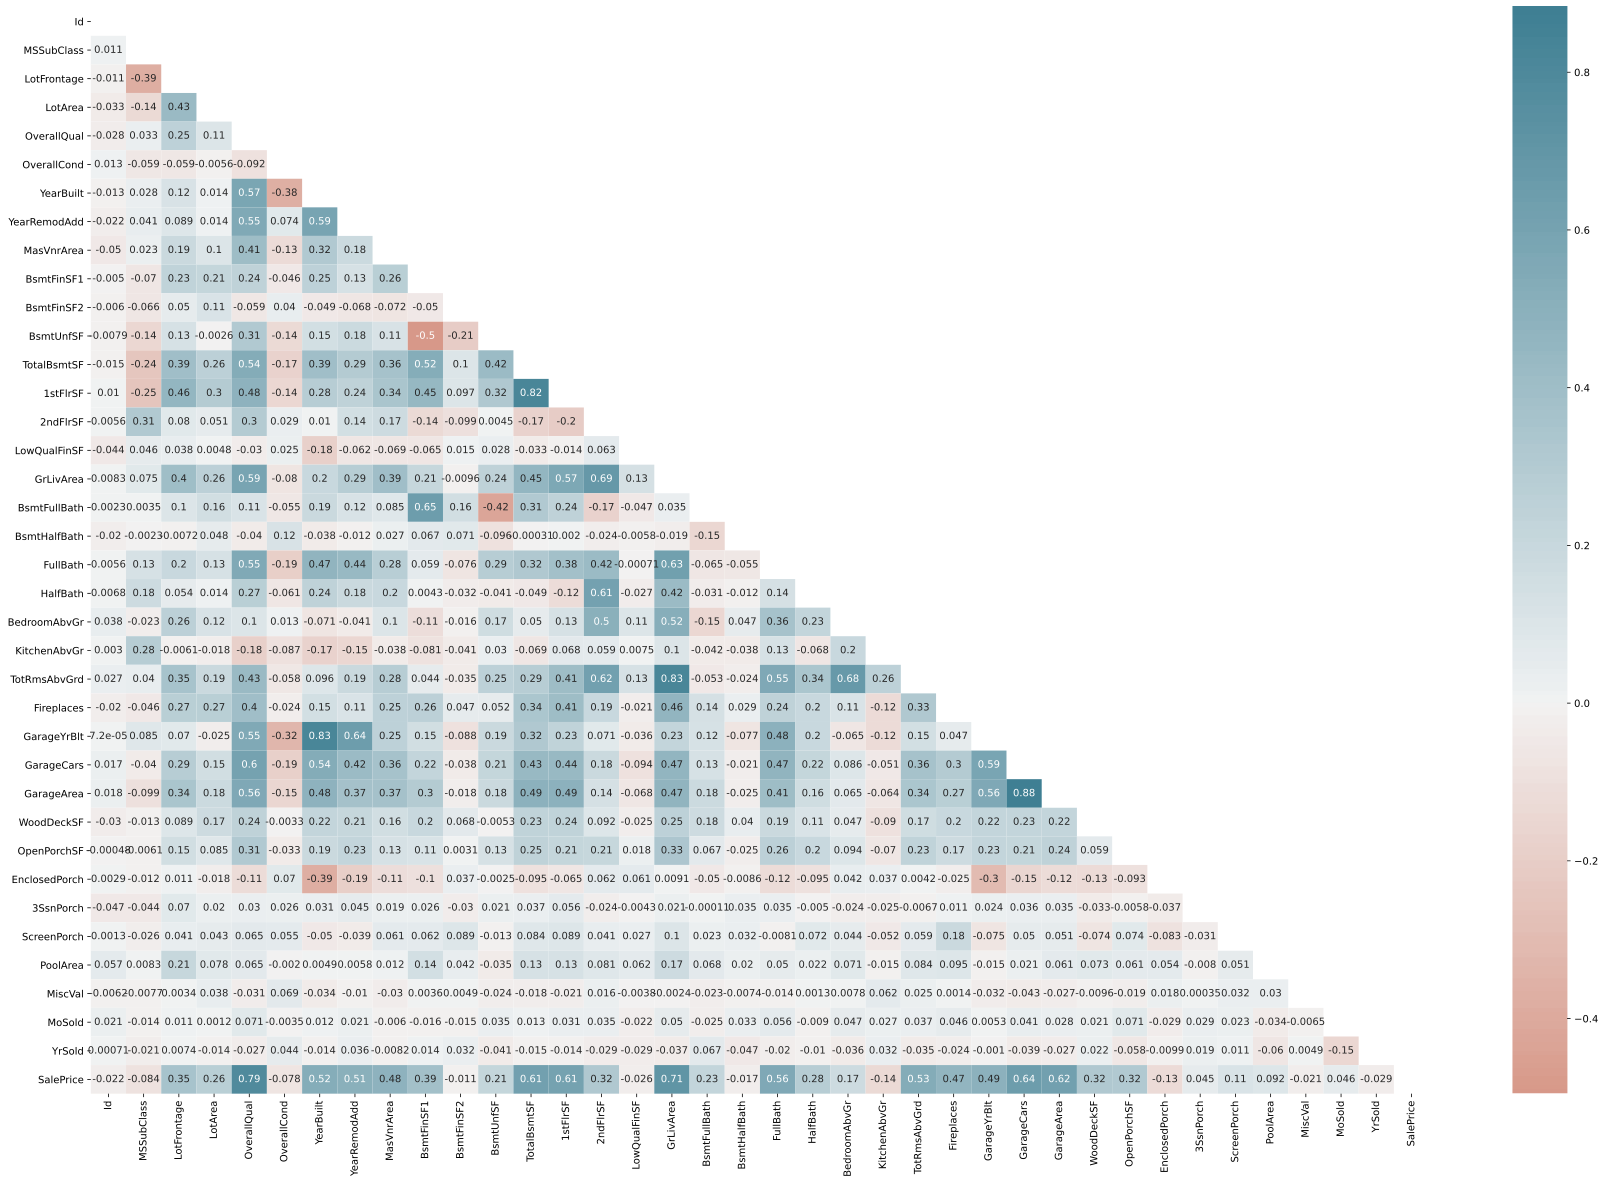

In [ ]:
plt.figure(figsize = (30,20))
mask = np.zeros_like(train_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_data.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0)
plt.show()

We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it does not carry any information for prediction purposes. Hence, we remove it from the dataset before feeding the data into the model.

In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [ ]:
all_features.shape

(2919, 79)

Then, to put all features on a common scale, we standardize the data by rescaling features to zero mean and unit variance:
𝑥←𝑥−𝜇𝜎. 
To verify that this indeed transforms our feature (variable) such that it has zero mean and unit variance, note that  𝐸[𝑥−𝜇𝜎]=𝜇−𝜇𝜎=0  and that  𝐸[(𝑥−𝜇)^2]=(𝜎^2+𝜇^2)−2𝜇^2+𝜇^2=𝜎^2 . Intuitively, we standardize the data for two reasons. First, it proves convenient for optimization. Second, because we do not know a priori which features will be relevant, we do not want to penalize coefficients assigned to one feature more than on any other.

In [ ]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

We replace them by a one-hot encoding in the same way that we previously transformed multiclass labels into vectors. For instance, “MSZoning” assumes the values “RL” and “RM”. Dropping the “MSZoning” feature, two new indicator features “MSZoning_RL” and “MSZoning_RM” are created with values being either 0 or 1. According to one-hot encoding, if the original value of “MSZoning” is “RL”, then “MSZoning_RL” is 1 and “MSZoning_RM” is 0.

In [ ]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

Finally, via the values attribute, we can extract the NumPy format from the pandas format and convert it into the tensor representation for training.

In [ ]:
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(train_data.SalePrice.values.reshape(-1, 1), dtype=tf.float32)

# **Train Neural Network Model**

To get started we train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it provides a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

In [ ]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    '''
    net.add(tf.keras.layers.Dense(
        2, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    net.add(tf.keras.layers.Dropout(.2))
    '''
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

With house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error  𝑦−𝑦̂ 𝑦  than about the absolute error  𝑦−𝑦̂  . For instance, if our prediction is off by USD 100,000 when estimating the price of a house in Rural Ohio, where the value of a typical house is 125,000 USD, then we are probably doing a horrible job. On the other hand, if we err by this amount in Los Altos Hills, California, this might represent a stunningly accurate prediction (there, the median house price exceeds 4 million USD).

One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. In fact, this is also the official error measure used by the competition to evaluate the quality of submissions. After all, a small value  𝛿  for  |log𝑦−log𝑦̂ |≤𝛿  translates into  𝑒−𝛿≤𝑦̂ 𝑦≤𝑒𝛿 . This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

(4.10.2)¶
1𝑛∑𝑖=1𝑛(log𝑦𝑖−log𝑦̂ 𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷.

In [ ]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

#**𝐾 -Fold Cross-Validation**
We will use k-fold cross validation for hyperparameter tuning.

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# **Model Selection**

In [ ]:
# create a separate validation/dev set for hyperparameter tuning 25% split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_features.numpy(), train_labels.numpy(), test_size=0.25, random_state=42)

fold 1, train log rmse 0.136430, valid log rmse 0.145946
fold 2, train log rmse 0.131314, valid log rmse 0.197184
fold 3, train log rmse 0.131278, valid log rmse 0.165078
fold 4, train log rmse 0.141438, valid log rmse 0.126821
fold 5, train log rmse 0.140593, valid log rmse 0.131894
5-fold validation: avg train log rmse: 0.136210, avg valid log rmse: 0.153385


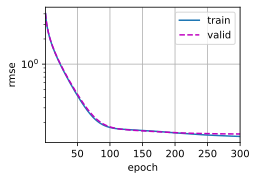

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 5, 0, 64
train_l, valid_l = k_fold(k, X_train, y_train, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

#**Prediction on Validation Set**

In [ ]:
net = get_net()
train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
valid = log_rmse(y_valid, net(X_valid))
print("log rmse on validation set:{:.3f}".format(valid.numpy()))

log rmse on validation set:0.126


#**Submitting Test Dataset Predictions on Kaggle**

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just  1−1/𝐾  of the data that are used in the cross-validation slices). The model that we obtain in this way can then be applied to the test set. Saving the predictions in a csv file will simplify uploading the results to Kaggle.



One nice sanity check is to see whether the predictions on the test set resemble those of the  𝐾 -fold cross-validation process. If they do, it is time to upload them to Kaggle. The following code will generate a file called submission.csv.

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = d2l.numpy(net(test_features))
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return net

train log rmse 0.127770


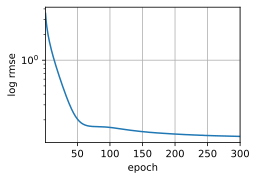

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)